# GPLVMs

This work is based on the original [GPLVM paper by Neil Lawrence (2005)](https://www.jmlr.org/papers/volume6/lawrence05a/lawrence05a.pdf). The goal of the notebook is to explain and provide some intuition for how GPLVMs work. 

## Theory

PPCA assumes  a model 

$$x = Wt + e,$$

where $W$ is a linear mapping from the latent space to the observed space,  $\vec e \sim N(0, \beta I)$.
By placing placing a prior over either t or W, marginalizing it out and optimizing the positions of the other one. 

If you place a spherical gaussian prior over W (see paper sec 2.3 of [Lawrence (2005)](https://www.jmlr.org/papers/volume6/lawrence05a/lawrence05a.pdf) for details) and marginalising it out, you get an independent Gaussian process prediction for each dimension of x:
$$
p(x_{:,d}|X, \beta) = N(x_{:,d}|0, X X^T + \beta I). 
$$
The Gram matrix $X^TX$ is simply the linear kernel between each pair of data points ($x_i^T x_j$). By changing the prior distribution of functions that you are marginalising over you can get different kernels, resulting in a nonlinear mapping from the latent to the observed space. Unfortunately when the kernel is changed from a linear kernel to some other kernel, the positions of the points in the latent space needs to be learnt. This is done using gradient descent on the posterior distribution of the points in the latent space, but requires some caution as the problem is non-convex so a good starting position is required to find an accurate latent space. One good starting position is taken the linear principle component analysis positions for the points. 

## Example 

Here I present a simple example with a one dimensional non-linear latent space to be found using a GPLVM. 


We want to estimate a relationship

$$
x = f(t) + e.
$$

In this particular example 

$$
x = [sin(t) + e_1, t^3/8 + e_2],
$$

 Where $\vec e \sim N(0, 0.1 I)$.

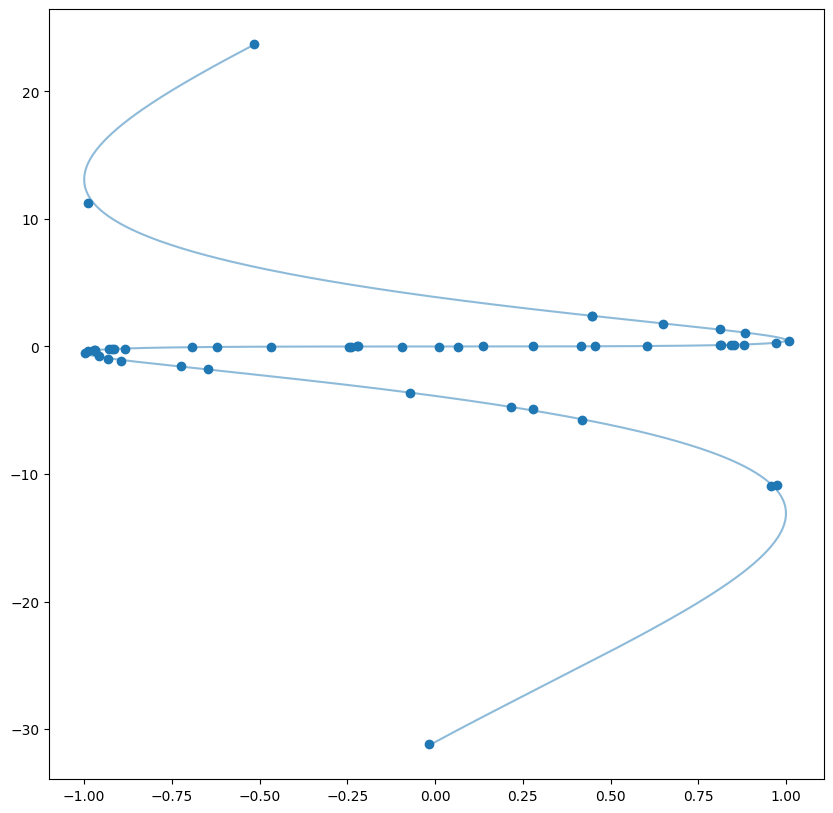

In [56]:
import numpy as np
import numpy.random as rand
import numpy.linalg as lin
import matplotlib.pyplot as plt

rand.seed(12)
N = 50

t = rand.normal(0,2,N)

x1 = np.sin(t) + rand.normal(0,0.01,N)
x2 = t**3/8  + rand.normal(0,0.01,N)

x1 = x1 
x2 = x2 

X = np.vstack([x1,x2]).T

t_linear = np.linspace(np.min(t),np.max(t),1000)
x1_linear = np.sin(t_linear) 
x2_linear = t_linear**3/8 

plt.figure(figsize= (10,10))
plt.scatter(x1,x2, label = "observed data")
plt.plot(x1_linear, x2_linear, alpha = 0.5, label = "true latent space")
plt.show()

### Step 1: Do a PCA

As mentioned in the introduction, we will be learning the positions of the points in latent space using gradient descent. The normal starting point is to attempt to reconstruct the data using PCA, despite the fact that the reconstruction using the linear kernel can be considerably different from the observed data. 



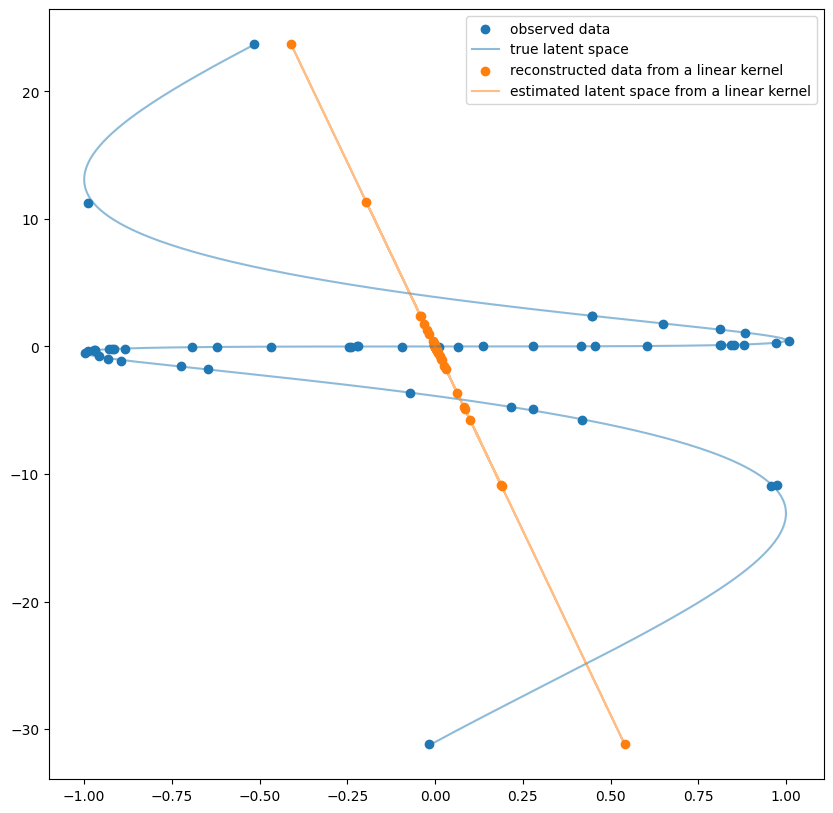

In [57]:
T, Sigma, P = np.linalg.svd(X, full_matrices= False)

t0 = T[:,0]*Sigma[0]
P0 = P[0]

x_recon = np.outer(t0 , P0)

theta_rbf = 1 
gamma = 0.5

plt.figure(figsize= (10,10))
plt.scatter(x1,x2, label = "observed data")
plt.plot(x1_linear, x2_linear, alpha = 0.5, label = "true latent space")
plt.scatter(x_recon[:,0], x_recon[:,1], label = "reconstructed data from a linear kernel")
plt.plot(x_recon[:,0], x_recon[:,1], alpha = 0.5, label = "estimated latent space from a linear kernel")
plt.legend()
plt.show()


<h2>Step 2: Change the Kernel </h2>

Here we change out the linear kernel for the exponential kernel. As the positions of the points in the latent space are incorrect for this kernel, the latent space which is found is very inaccurate. 

log posterior:  -1779.1380991813846


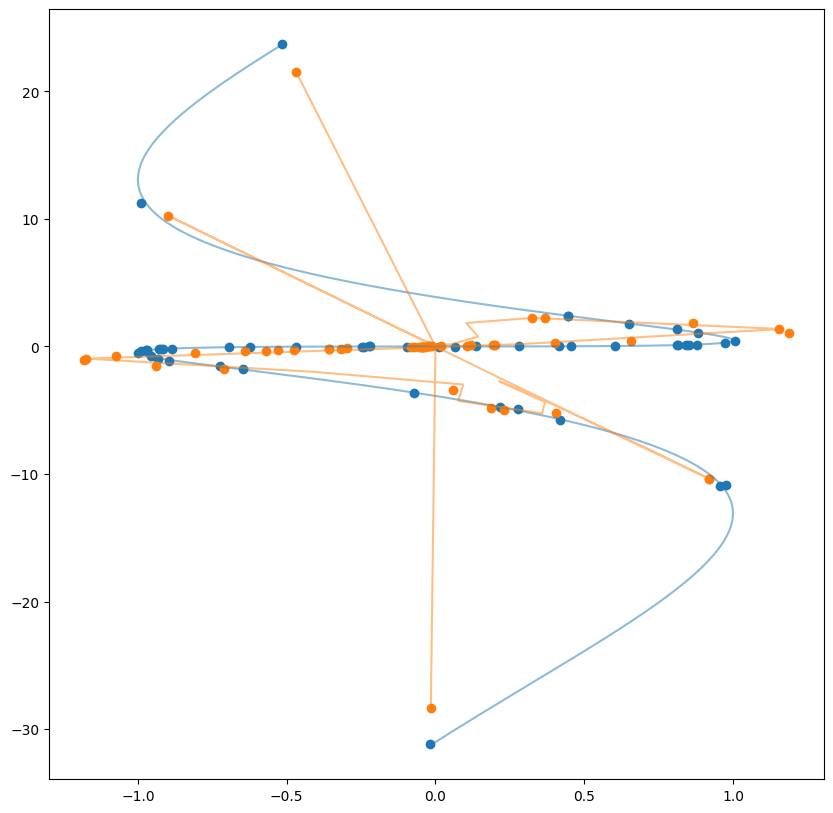

In [58]:
def rbf(x1,x2, gamma =gamma, theta_rbf = theta_rbf, theta_white = 0.1, theta_bias = 0, delta = False):
    return theta_rbf*np.exp(- gamma/2 * np.inner(x1-x2, x1- x2)) + theta_bias + theta_white*delta 

# %%
def GP_predict_mean(ti,T, x, N = N):
    K12 = np.empty(N)
    K22 = np.empty((N,N))
    for i in range(N):
        K12[i] = rbf(ti,T[i])
        for j in range(N):
            if i == j:
                K22[i,j] = rbf(T[i],T[j], delta = True)
            else:
                K22[i,j] = rbf(T[i],T[j])
    return K12@lin.inv(K22)@x

K = np.zeros((N,N))                 # New covariance matrix
for i in range(N):
    for j in range(N):
        if i == j:
            K[i,j] = rbf(t[i],t[j], delta = True)
        else:
            K[i,j] = rbf(t[i],t[j], delta = False)


K_inv = lin.inv(K)
P= - (N)* np.log(2* np.pi) - np.log(lin.det(K)) - 1/2 *np.trace(K_inv @ X @ X.T) - (N/2)* np.log(2* np.pi) - 1/2 * np.inner(t0,t0)

print("log posterior: ", P)

t_range = np.linspace(np.min(t0),np.max(t0),50)
x1_mean = np.zeros(50)
x2_mean = np.zeros(50)

for i in range(50):
    # print(t_range[i], GP_predict_mean(t_range[i],t_est,x1))
    x1_mean[i] = GP_predict_mean(t_range[i],t0,x1)
    x2_mean[i] = GP_predict_mean(t_range[i],t0,x2)

x1_points = np.zeros(50)
x2_points = np.zeros(50)   

for i in range(N):
    x1_points[i] = GP_predict_mean(t0[i],t0,x1)
    x2_points[i] = GP_predict_mean(t0[i],t0,x2)

plt.figure(figsize= (10,10))
plt.scatter(x1,x2, label = "observed data")
plt.plot(x1_linear, x2_linear, alpha = 0.5, label = "true latent space")
plt.scatter(x1_points, x2_points, label = "reconstructed data from an RBF kernel")
plt.plot(x1_mean, x2_mean, alpha = 0.5, label = "estimated latent space from a RBF kernel")
plt.show()


## Step 3: Optimise the positions of the points in the latent space using gradient descent

$T$ is a matrix of size $N \times 1$ as we only have 1 latent variable.

In order to optimise the positions of the latent variables, we start with the fact that 

$$
\frac{\partial L}{\partial K} = K^{-1}X X^T K ^{-1} - DK^{-1},
$$
regardless of which kernel is used to find K. _Note: this produces an $N\times N$ matix._ 


It is also possible to find the $N \times N$ matrix for $\frac{\partial K}{\partial t_i},$ 
where $t_i$ is the $N$th latent variable. In order to convert this back to a single component it is necessary to sum over all elements of the elementwise product of these matriceis: 

$$
\frac{\partial L}{\partial t_i} = \sum_{ j= 1}^N \sum_{k = 1}^N \left(\frac{\partial L}{\partial K}\right)_{j,k} \frac{\partial K_{j,k}}{\partial t_i}.
$$

When a prior is included there is an additional term $\frac{\partial \textrm{prior prob}}{\partial t_i}$, so the whole term is 

$$
\frac{\partial P}{\partial t_i} = - t_i + \sum_{ j= 1}^N \sum_{k = 1}^N \left(\frac{\partial L}{\partial K}\right)_{j,k} \frac{\partial K_{j,k}}{\partial t_i} .
$$




mod grad t 102.0179264906462 
 det K 2.2870281559234597e-37 Log posterior -1936.0528663961695


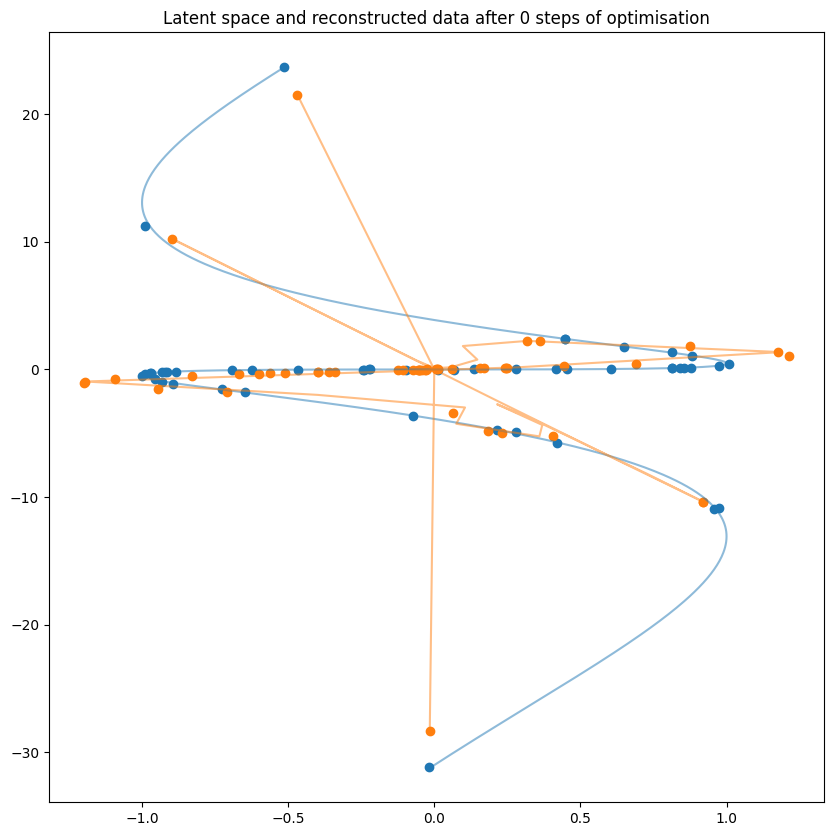

mod grad t 31.870124284688778 
 det K 4.187341797552945e-38 Log posterior -1892.900866344508


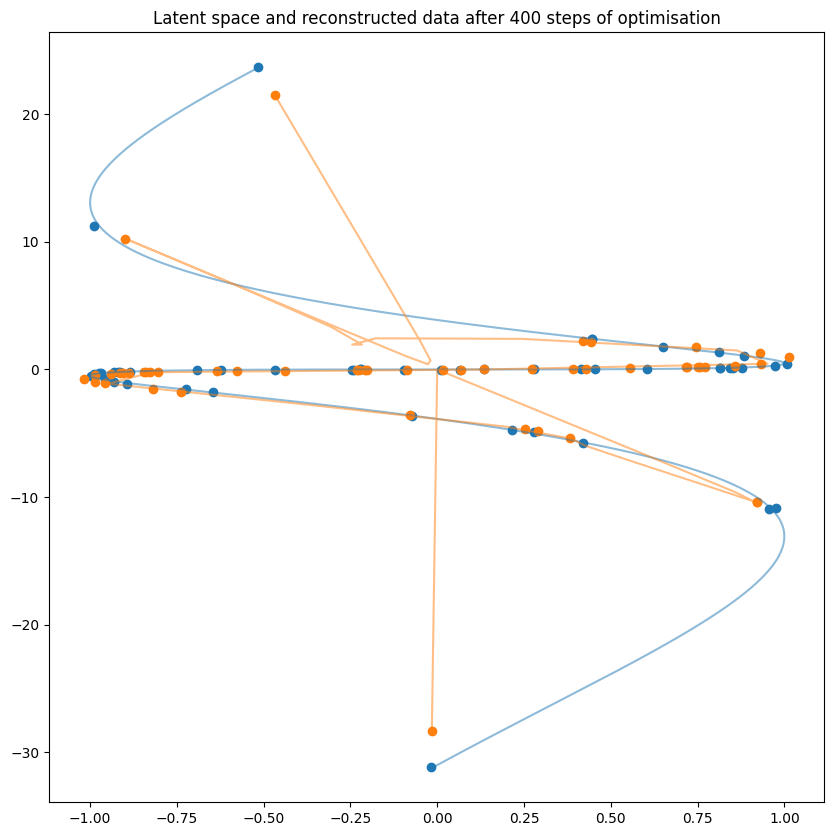

mod grad t 19.478794874396947 
 det K 2.6271966009600907e-39 Log posterior -1873.9568424874642


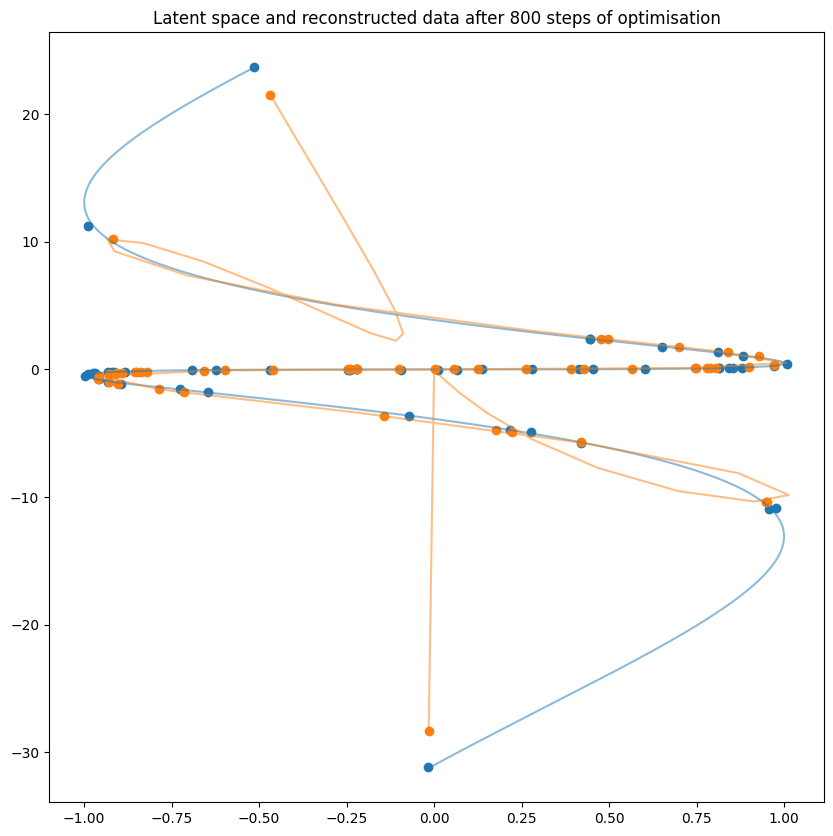

mod grad t 16.343129138819183 
 det K 1.0350992770697364e-39 Log posterior -1818.176904664933


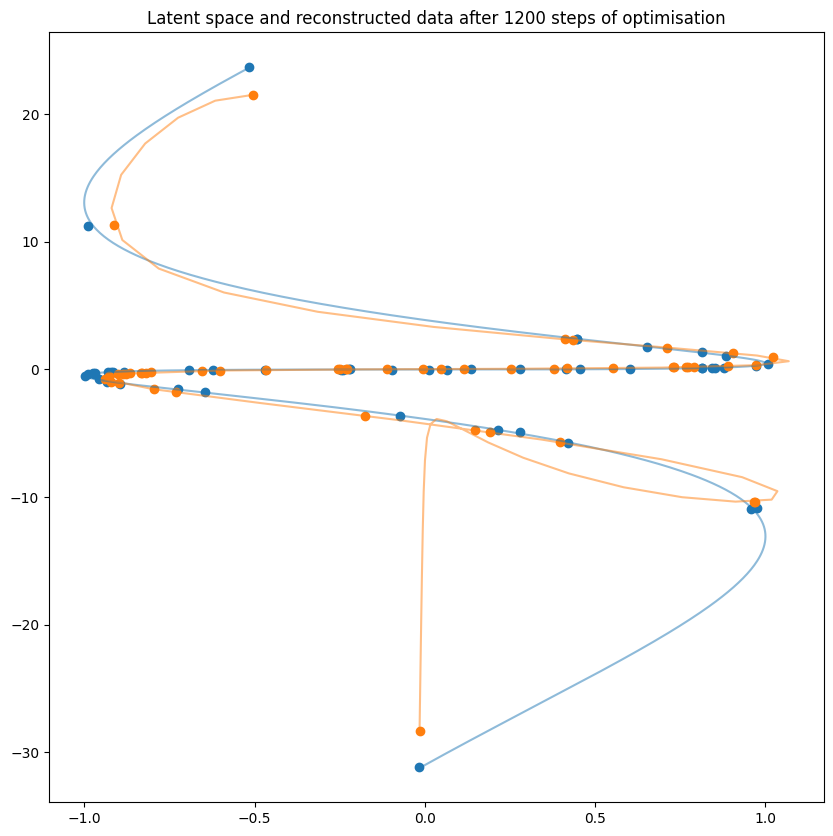

mod grad t 6.310299215078662 
 det K 5.891394789099869e-41 Log posterior -1758.1883220676639


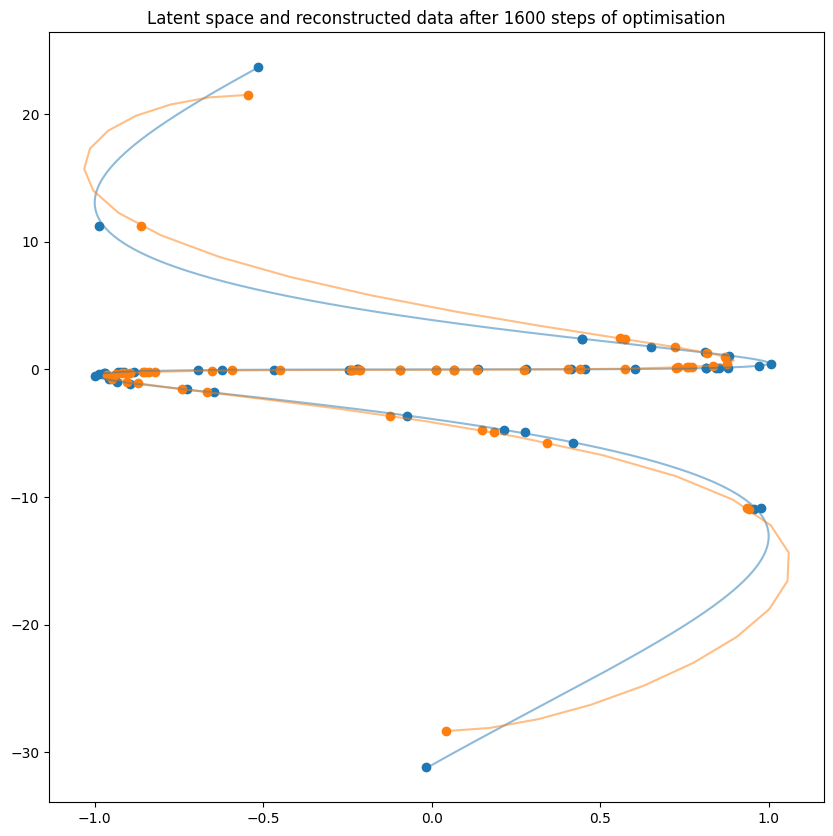

mod grad t 333.0274828603157 
 det K 4.653770513349561e-41 Log posterior -1774.3691811144952


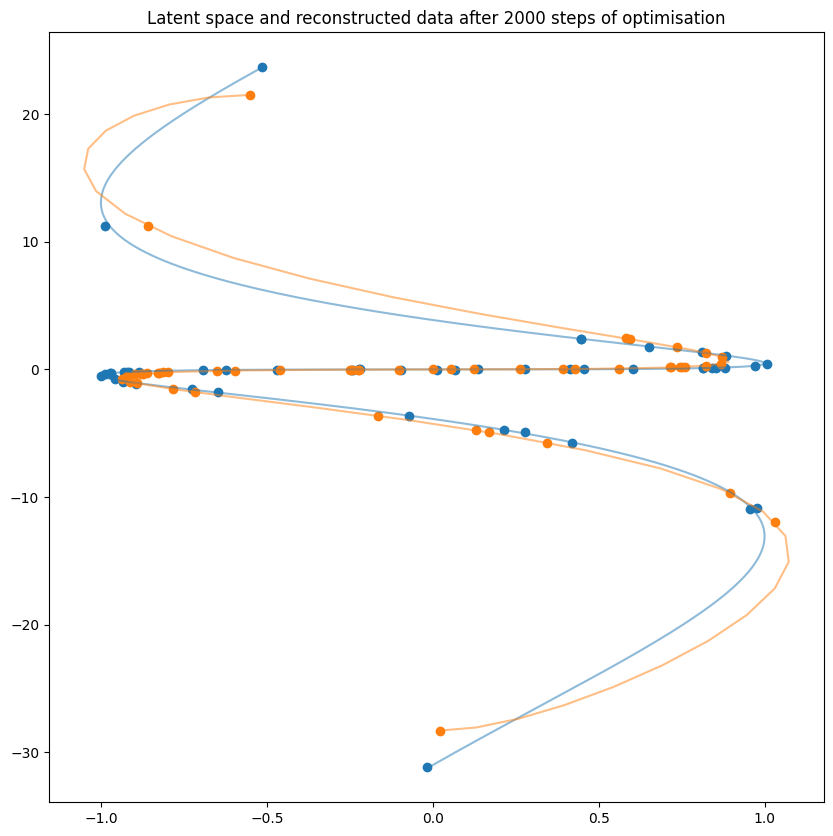

In [59]:
def dk_dt(xi,xj, gamma = gamma, theta_rbf = theta_rbf):
    return -gamma*(xi - xj)*theta_rbf*np.exp(-gamma/2*(xi - xj)**2)



def dK_dt(i, t = t0, N = N):
    dK = np.zeros((N,N))
    for j in range(N):
        if j == i:
            dK[i,j] = 0
        else:
            dK[i,j] = dk_dt(t[i],t[j])
    for j in range(N):
        if j == i:
            dK[j,i] = 0
        else:
            dK[j,i] = dk_dt(t[i],t[j])
    return dK

t_est = t0
dt = np.empty(N)
m = 0 

n_opt = 2001
for i in range(n_opt):

    K = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i == j:
                K[i,j] = rbf(t_est[i],t_est[j], delta = True)
            else:
                K[i,j] = rbf(t_est[i],t_est[j], delta = False)

    K_inv = lin.inv(K)

    dL_dK = K_inv@X@X.T@K_inv - 2*K_inv
    for i in range(N):
        dt[i] = np.sum(dK_dt(i, t_est)*dL_dK) - t_est[i] # -t_est term is from the prior

    K_inv = lin.inv(K)
    t_est = t_est + 1e-3*dt
    P= - (N)* np.log(2* np.pi) - np.log(lin.det(K)) - 1/2 *np.trace(K_inv @ X @ X.T) - (N/2)* np.log(2* np.pi) - 1/2 * np.inner(t0,t0)
    # print("L", L, "\n t", t_est, "\n dt", dt )
    if m%(n_opt//5) == 0:
        print("mod grad t", lin.norm(dt)
        ,"\n det K", lin.det(K)
        , "Log posterior", P,
        # "\nt", t_est
        )

        t_range = np.linspace(np.min(t_est),np.max(t_est),50)
        x1_mean = np.zeros(50)
        x2_mean = np.zeros(50)

        

        for i in range(50):
            # print(t_range[i], GP_predict_mean(t_range[i],t_est,x1))
            x1_mean[i] = GP_predict_mean(t_range[i],t_est,x1)
            x2_mean[i] = GP_predict_mean(t_range[i],t_est,x2)

        x1_points = np.zeros(50)
        x2_points = np.zeros(50)   

        for i in range(N):
            x1_points[i] = GP_predict_mean(t_est[i],t_est,x1)
            x2_points[i] = GP_predict_mean(t_est[i],t_est,x2)


        plt.figure(figsize= (10,10))
        plt.title("Latent space and reconstructed data after {} steps of optimisation".format(m))
        plt.scatter(x1,x2, label = "observed data")
        plt.plot(x1_linear, x2_linear, alpha = 0.5, label = "true latent space")
        plt.scatter(x1_points, x2_points, label = "reconstructed data from an RBF kernel")
        plt.plot(x1_mean, x2_mean, alpha = 0.5, label = "estimated latent space from a RBF kernel")
        plt.show()

        # plt.figure()
        # plt.scatter(t,dt)
        # plt.xlabel("t")
        # plt.ylabel("dt")
        # plt.show()
    m +=1 

## Visualising the outputs 

- The outputs are independent gaussian processes so we can plot the prediction of each veraiable independantly 
- We can also look at how well the model has recovered the original values for t 


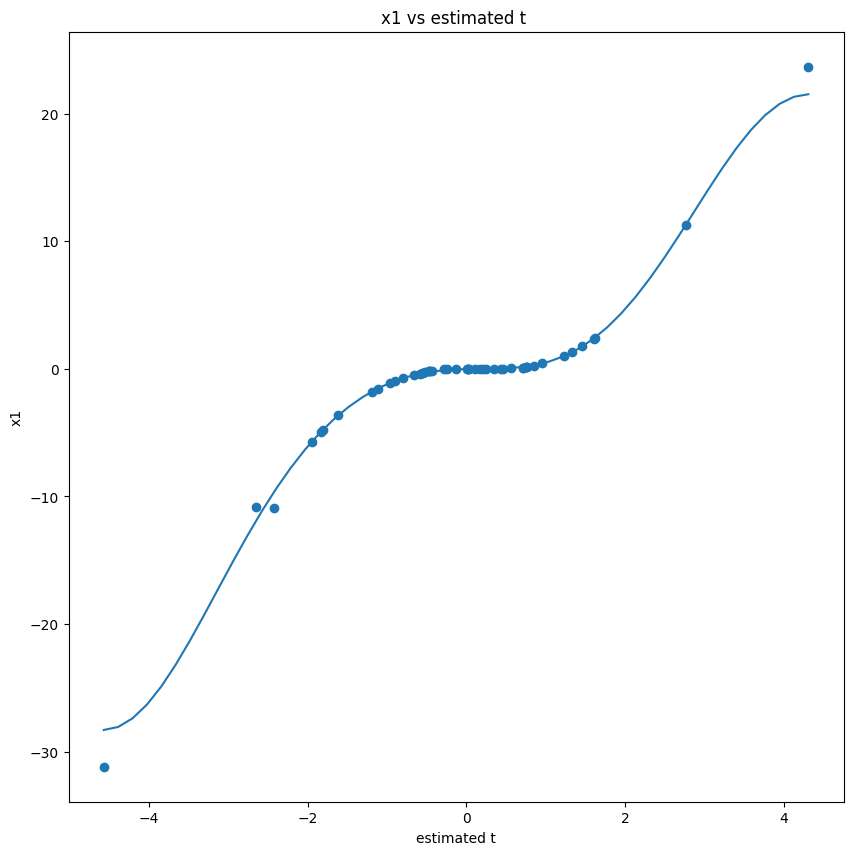

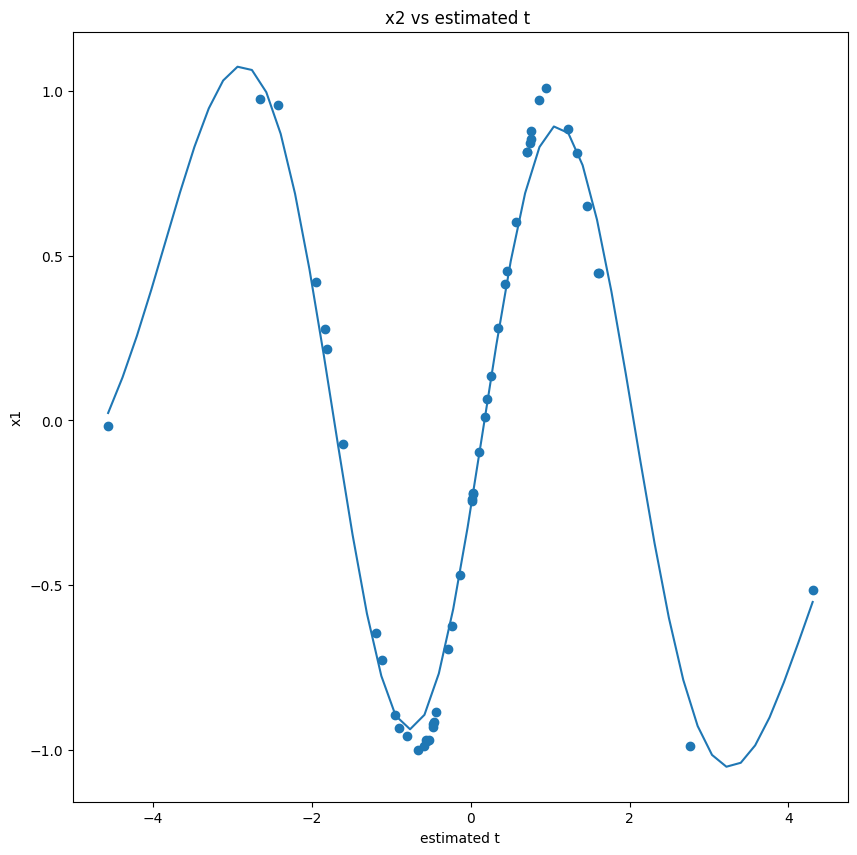

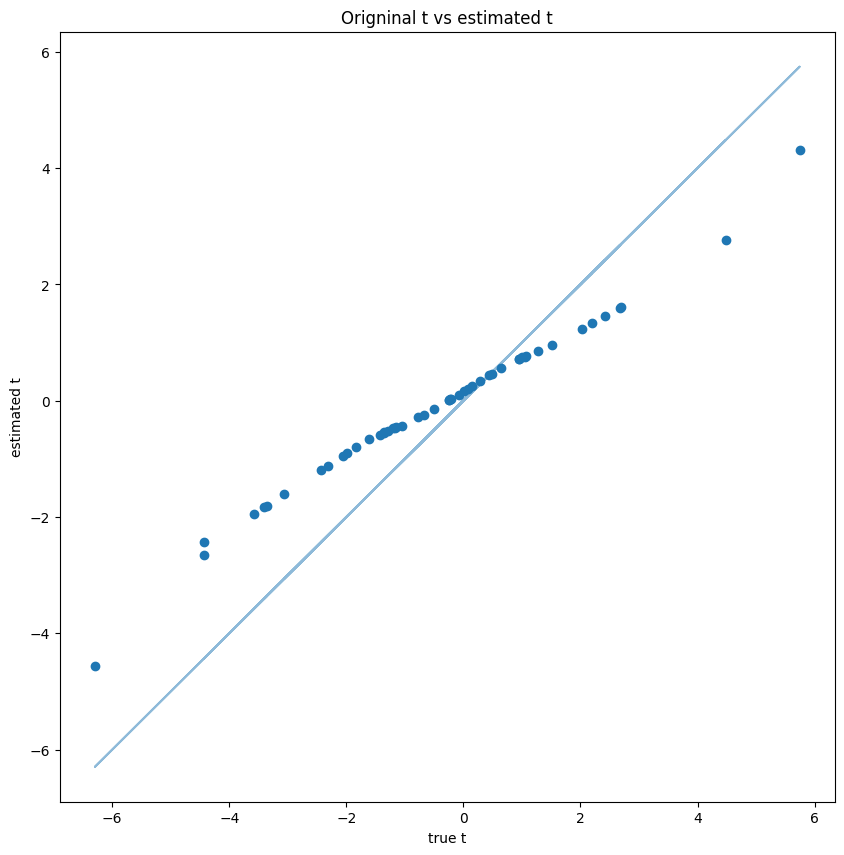

In [60]:
# %%

plt.figure(figsize=(10,10))
plt.title("x1 vs estimated t ")
plt.scatter(t_est, x2)
plt.plot(t_range,x2_mean)
plt.xlabel("estimated t")
plt.ylabel("x1")
plt.show()

plt.figure(figsize=(10,10))
plt.title("x2 vs estimated t ")
plt.scatter(t_est, x1)
plt.plot(t_range,x1_mean)
plt.xlabel("estimated t")
plt.ylabel("x1")
plt.show()




# %%
plt.figure(figsize=(10,10))
plt.title("Origninal t vs estimated t")
plt.scatter(t, t_est)
plt.plot(t,t, alpha = 0.5,  label = "estimated value = true value")
plt.xlabel("true t")
plt.ylabel("estimated t")
plt.show()
# %%